# Analyzing sampling result

In this tutorial, we will show how to analyze the sampling result from `flowMC` using [`arviz`](https://arviz-devs.github.io/arviz/). In particular, we will look at $\hat{R}$ and effective sample size (ESS) to check convergence and efficiency of the sampling result.

We will use the "dual moon" distribution from the first tutorial as a testbed. 

In [4]:
import jax
import jax.numpy as jnp  # JAX NumPy
from jax.scipy.special import logsumexp

n_dim = 5

def target_dualmoon(x, data):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    print("compile count")
    term1 = 0.5 * ((jnp.linalg.norm(x-data) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))


We will run two versions of the sampler to compare diagnostics on the chains: 
- A full-version of `flowMC` 
- A version where we deactivate the use of global MCMC steps using the Normalizing Flow. This boils down to a traditional local MCMC, here the Metropolis-Adjusted Lagevin algorithm.  

## Setting up and running the samplers 

In [5]:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

# Set up the parameters
n_chains = 20

n_loop_training = n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

step_size = 1e-1  # step size for MALA

print("Preparing RNG keys")

rng_key_set = initialize_rng_keys(n_chains, seed=42)

print("Initializing chains, normalizing flow model and local MCMC sampler")

initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1
model = MaskedCouplingRQSpline(n_dim, 4, [32,32], 8 , jax.random.PRNGKey(10))
MALA_Sampler = MALA(target_dualmoon, True, {"step_size": step_size})

print("Initializing samplers classes")

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    jnp.zeros(5),
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

local_sampler = Sampler(
    n_dim,
    rng_key_set,
    jnp.zeros(5),
    MALA_Sampler,
    model,
    n_loop_training=0,
    n_loop_production=1,
    n_local_steps=n_local_steps * (n_loop_production + n_loop_training),
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=False,
)


Preparing RNG keys
Initializing chains, normalizing flow model and local MCMC sampler
Initializing samplers classes
jit is requested, precompiling kernels and update...
compile count
compile count
jit is requested, precompiling kernels and update...
compile count


In [9]:
print("Running local sampling")

local_sampler.sample(initial_position,  jnp.zeros(n_dim))
summary_local = local_sampler.get_sampler_state()
chains_local, log_prob_local, local_accs_local, global_accs_local = summary_local.values()

Running local sampling
No autotune found, use input sampler_params
Starting Production run


Production run:   0%|          | 0/1 [00:00<?, ?it/s]

Production run: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


In [10]:
print("Running flowMC sampling")
nf_sampler.sample(initial_position, jnp.zeros(n_dim))
summary = nf_sampler.get_sampler_state()
chains, log_prob, local_accs, global_accs = summary.values() 

Running flowMC sampling
No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/20 [00:00<?, ?it/s]

compile count


Tuning global sampler: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Starting Production run


Production run: 100%|██████████| 20/20 [00:00<00:00, 35.38it/s]


## Analyzing the chains

To analyze the output of the chains we will use the widely package `arviz`. Arviz uses a specific type of data structure, `InferenceData` which we can easily convert to from numpy arrays. Since we only kept the production samples from the `flowMC` sampler, we also only consider get rid of the draws of the MALA samples in the bur-in phase

In [11]:
import arviz as az
import numpy as np

data = az.convert_to_inference_data(np.array(chains))
data_local = az.convert_to_inference_data(np.array(chains_local))

n_draws_local = data_local.posterior.dims['draw']

print("Number of total local samples: ", n_draws_local)

data_local_ = data_local.sel(draw=slice(1800, None))
n_draws_local_ = data_local_.posterior.dims['draw']
n_draws = data.posterior.dims['draw']
print("Number of samples: ", n_draws, "- Number of samples local: ", n_draws_local_)

Number of total local samples:  4000
Number of samples:  2200 - Number of samples local:  2200


After that, we can use the diagnostic tools implemented in arviz. To start with we can visualize the samples obtained by drawing the kernel density estimations in pair plots. At first sight, the local and the `flowMC` sampler look of comparable quality.

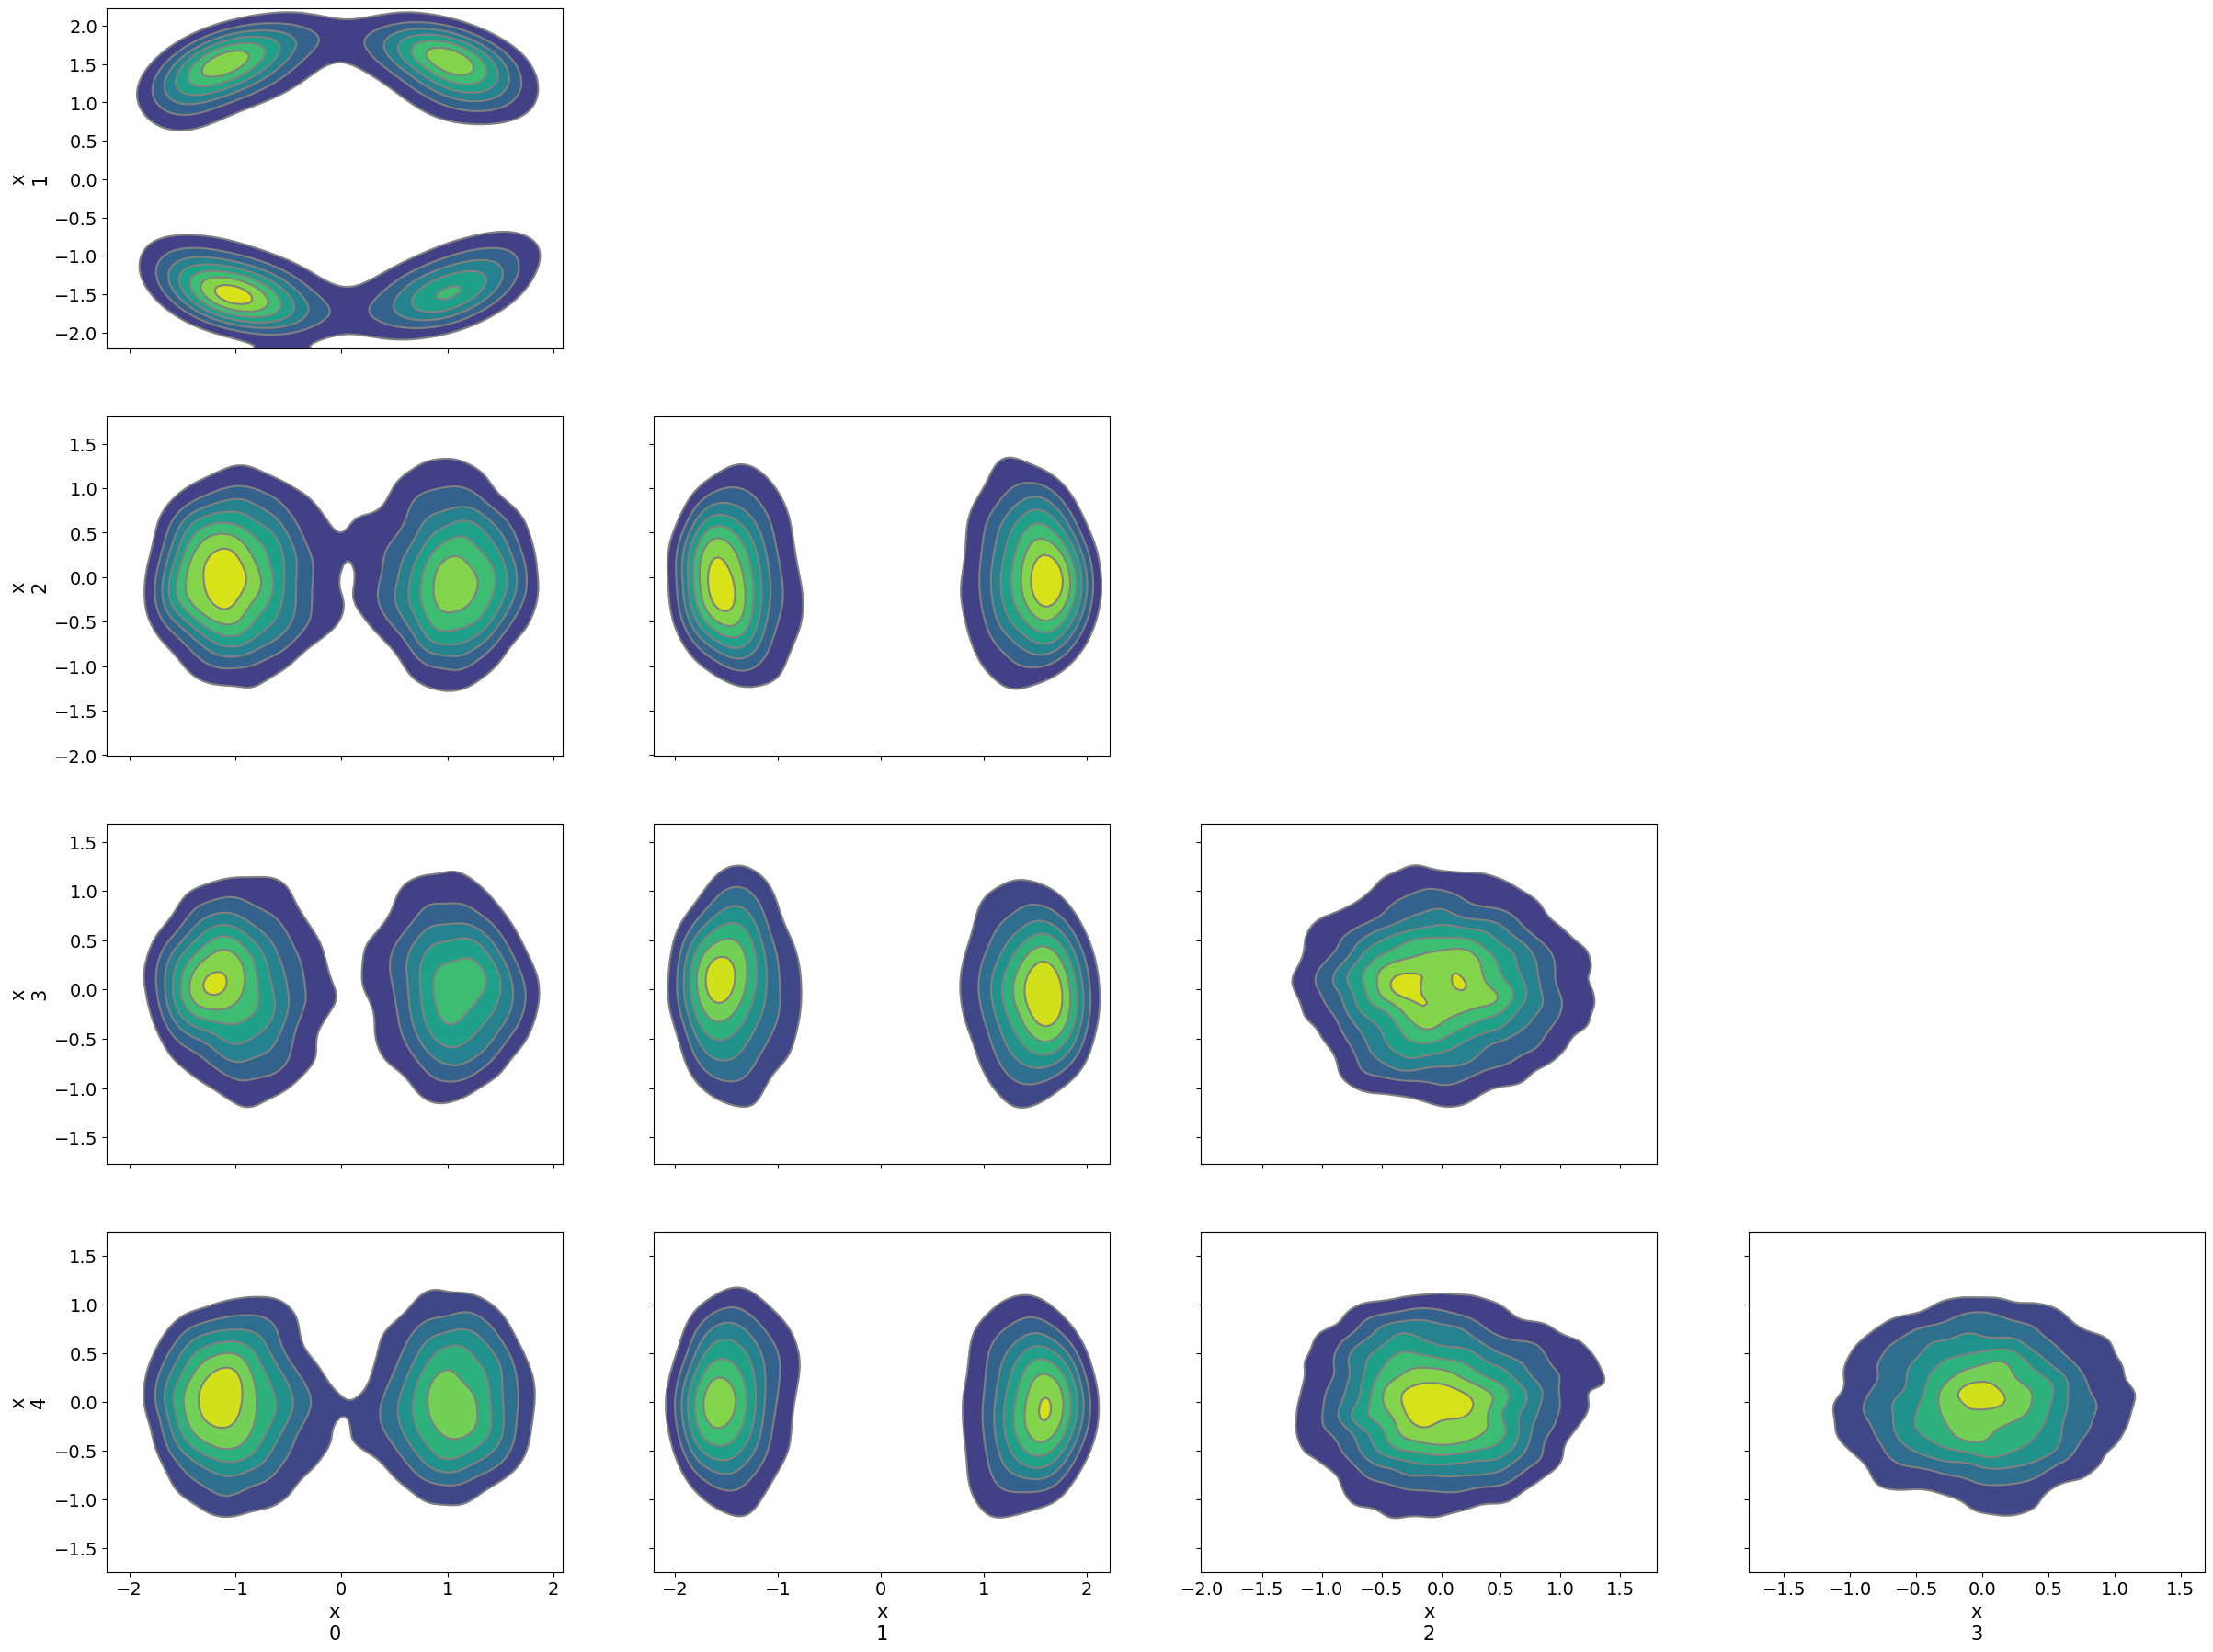

In [12]:

axes = az.plot_pair(data, kind='kde')


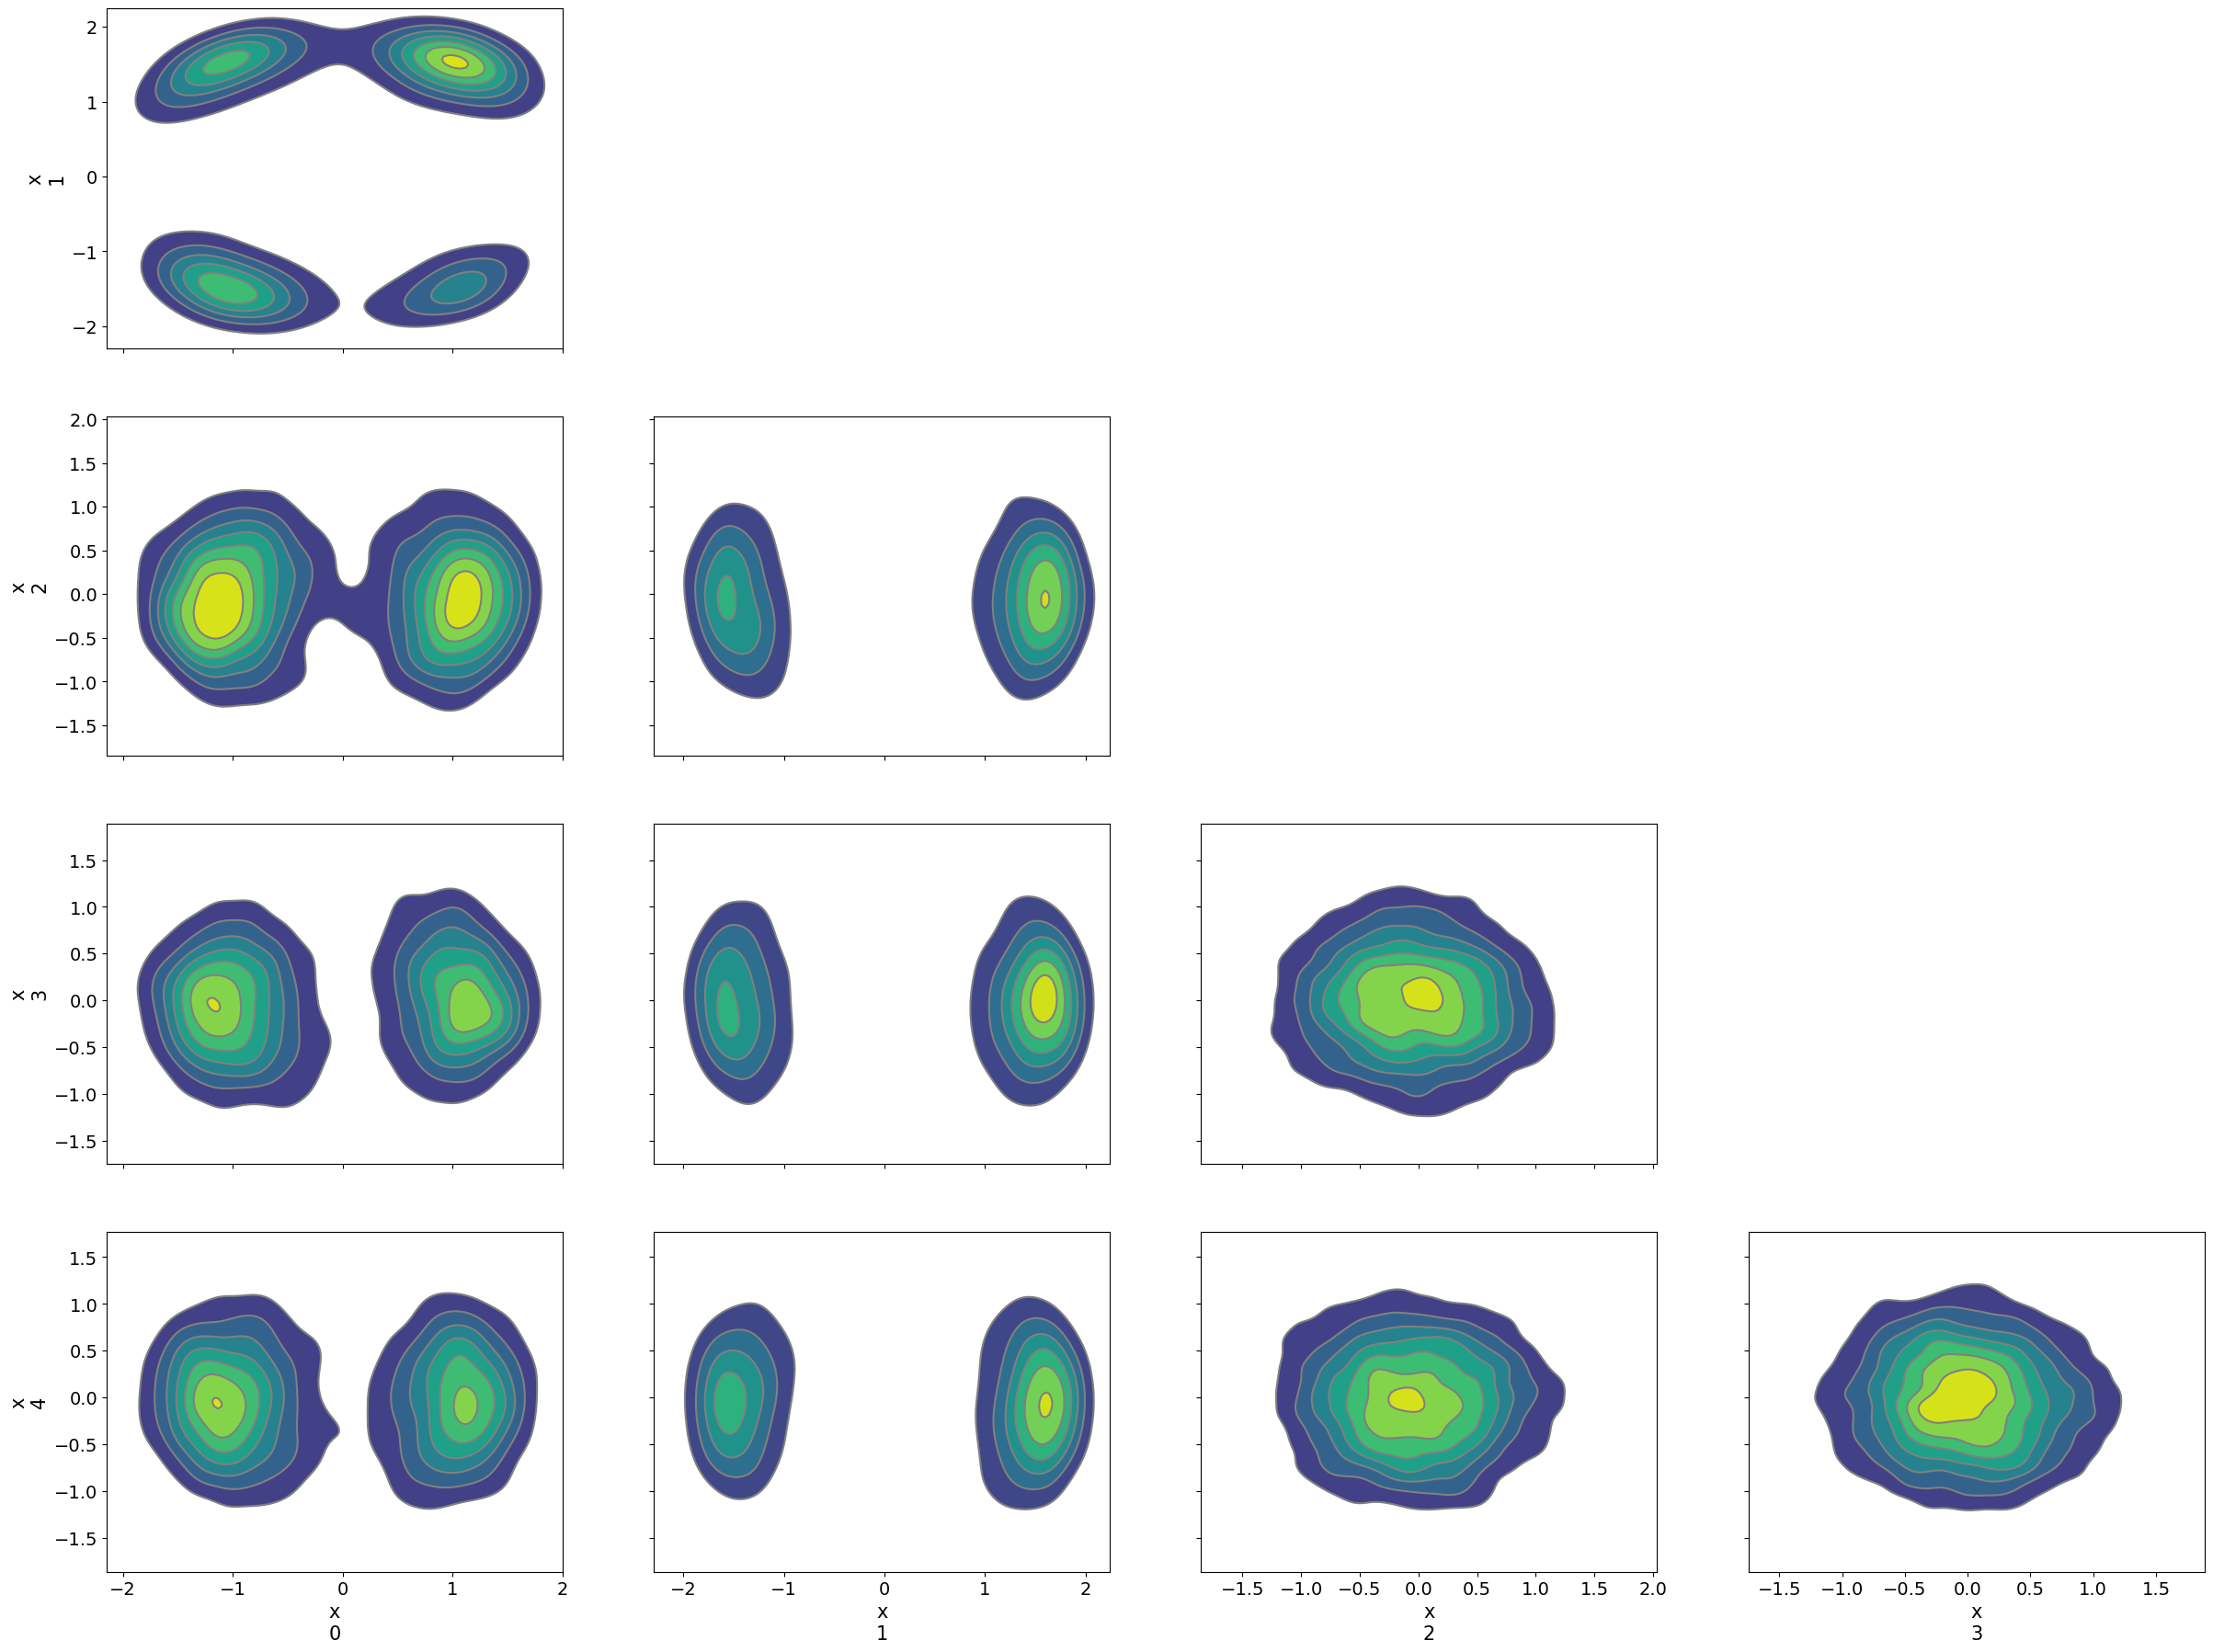

In [13]:
axes = az.plot_pair(data_local_, kind='kde')

However, if we consider the next sanity check we will see that the local sampler actually does not mix. This next check is to compute the [rhat](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html?highlight=rhat): $$\hat{R} = \frac{\text{inter-chain variance}}{\text{within-chain variance}}$$

When chains are properly mixing, a single chain has comparative variance to the pool of states visited by the batch of chains and $\hat{R} \to 1$. Conversely, when the chains are not mixing $\hat{R} > 1$. The results below show that MALA is not mixing along the dimensions where the marginal of the distribution are multimodal: `x_0`and `x_1`.

In [14]:
rhat_flownmc = az.rhat(data)
rhat_local = az.rhat(data_local_)

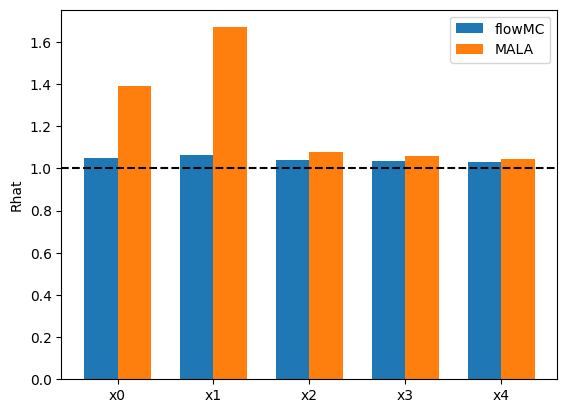

In [15]:
import matplotlib.pyplot as plt

width=0.35
x = data.posterior.x_dim_0.data

plt.bar(x - width/2,  rhat_flownmc.to_array().data.squeeze(), width, label='flowMC')
plt.bar(x + width/2,  rhat_local.to_array().data.squeeze(), width, label='MALA')
plt.axhline(1.0, color='k', linestyle='--')
plt.xticks(x, ['x{:d}'.format(i) for i in x])
plt.ylabel('Rhat')
plt.legend()


Another quantity of interest to compare the performance of sampling algorithms is to look at the effective sample size (ESS). This quantity is computed from an estimate of the autocorrelation of the chains and represents the number of samples that could be considered as independent within a given sample. 

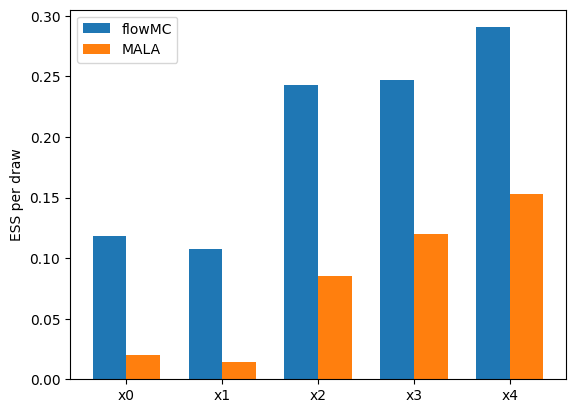

In [16]:
n_draws = data.posterior.draw.shape[0]

ess_flownmc = az.ess(data)
ess_local = az.ess(data_local_)

width=0.35
x = data.posterior.x_dim_0.data

plt.bar(x - width/2,  ess_flownmc.to_array().data.squeeze() / n_draws, 
        width, label='flowMC')
plt.bar(x + width/2,  ess_local.to_array().data.squeeze() / n_draws, 
        width, label='MALA')
plt.ylabel('ESS per draw')
plt.xticks(x, ['x{:d}'.format(i) for i in x])
plt.legend()

The global moves proposed by the normalizing flow of `flowMC` are completely independent from the previous state of the chain, hence when the global acceptance is none zero the decorrelation is very fast. Here we can see that it oscillates around $35\%$, hence the much better ESS for flowMC compared to MALA.

Text(0.5, 0, 'iteration')

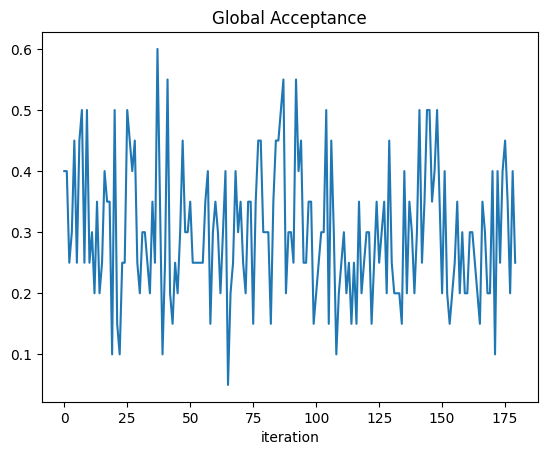

In [17]:
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")